In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from csgan.loader.colored_mnist_loader import ColoredMnistDataset
from csgan.model.cs_glow_model_huk import CSGlowMnistModel

In [3]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
#DATA_ROOT = '/data'
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [8]:
run_dir = os.path.join(RUN_ROOT, "mnist_cs_glow/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 16, 'test_batch_size': 512,
          'learning_rate': 0.0005, 'beta1': 0.9, 'beta2': 0.999,
          'scheduler_gamma': 1., 'weight_decay': 0., #0.00001,
          'n_bits': 5,
          'lambda_glow': 1.,
          'lambda_weight_cycle': 0.5, 'lambda_siamese': 0.5,
          'lambda_content': 0.1, 'lambda_style': 0.1,
          'gamma_content': 0.5, 'gamma_style': 0.5,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [5]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, dirname='colored_mnist_bg', image_size=32, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, dirname='colored_mnist_bg', image_size=32, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

3750 20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cs_model = CSGlowMnistModel(device, 'mnist_model_pre.pt')
#cs_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
cs_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00050000.

[1/200] 10'th step. [LOSS] 1.890623. [LOSS_GLOW] 1.485094. [LOSS_WEIGHT_CYCLE] 0.229262. [LOSS_CONTENT] 0.025954. [ACCURACY_CONTENT] 0.343750. [LOSS_STYLE] 0.036478. [ACCURACY_STYLE] 0.593750. [LOSS_SIAMESE] 0.151186. [NORM_S1] 0.547363. [NORM_S2] 0.567049
    Best Step:     10. Elapsed Time: 20.068344 seconds.
[1/200] 20'th step. [LOSS] 1.511661. [LOSS_GLOW] 1.302048. [LOSS_WEIGHT_CYCLE] 0.094688. [LOSS_CONTENT] 0.028907. [ACCURACY_CONTENT] 0.531250. [LOSS_STYLE] 0.020325. [ACCURACY_STYLE] 0.687500. [LOSS_SIAMESE] 0.075551. [NORM_S1] 0.387880. [NORM_S2] 0.382953
    Best Step:     20. Elapsed Time: 33.034682 seconds.
[1/200] 30'th step. [LOSS] 1.314469. [LOSS_GLOW] 1.187124. [LOSS_WEIGHT_CYCLE] 0.051032. [LOSS_CONTENT] 0.031638. [ACCURACY_CONTENT] 0.406250. [LOSS_STYLE] 0.019925. [ACCURACY_STYLE] 0.687500. [LOSS_SIAMESE] 0.048183. [NORM_S1] 0.309449. [NORM_S2] 0.316432
    Best Step:     30. Elapsed Time: 45.942667 seconds.
[1/200] 40'th ste

In [ ]:
all_input, all_output = cs_model.predict(test_loader)

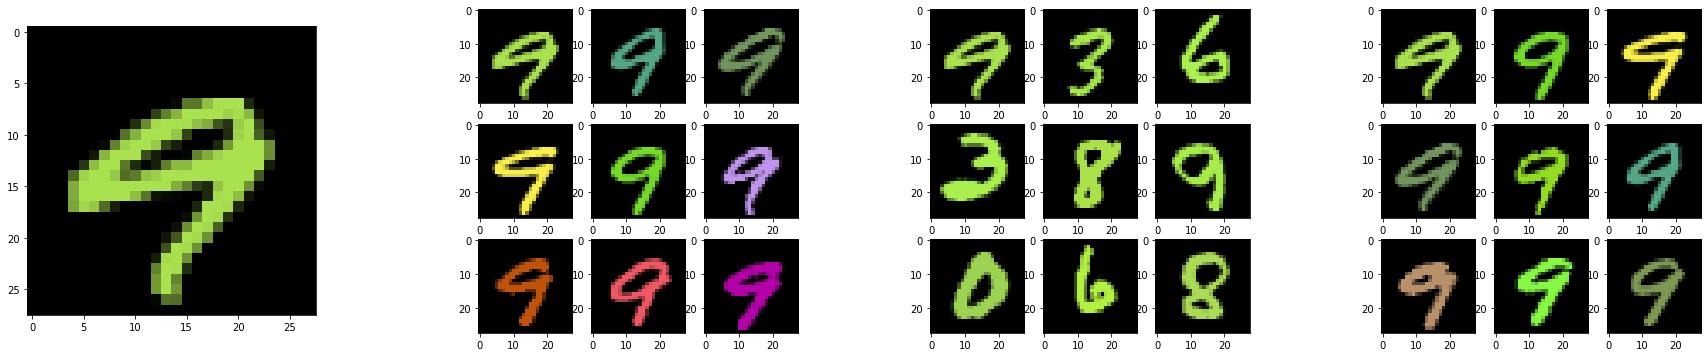

In [11]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()

In [8]:
4/89*100

4.49438202247191